In [177]:
import focusstack
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt

Plotting the first photo in the example set. The millimeter ruler to the right is used as a reference for depth, and is used to annotate the image file names.

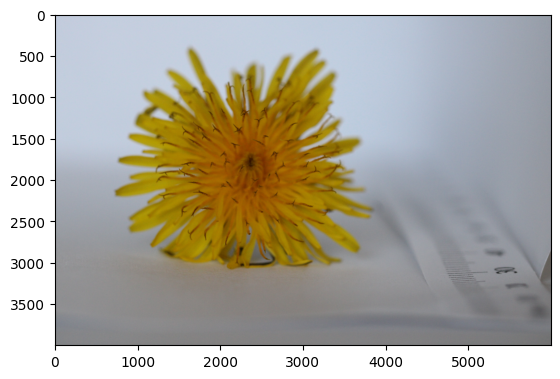

In [178]:
dir = "images/dandelion"
img = "IMG_29.JPG"
im = cv2.imread(f"{dir}/{img}")
plt.figure()
plt.imshow(im[:,:,[2,1,0]])

The images can be cropped durring processing to remove the sections of the photo with the ruler or with too much white space.

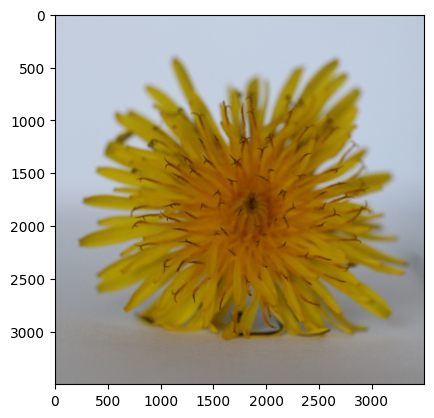

In [179]:
im_crop = im[:3500,500:4000,:]
plt.figure()
plt.imshow(im_crop[:,:,[2,1,0]])

In [180]:
print(im.shape)
print(im_crop.shape)

(4000, 6000, 3)
(3500, 3500, 3)


In [181]:
def resize_im(im, scale_percent):
    width = int(im.shape[1] * scale_percent / 100)
    height = int(im.shape[0] * scale_percent / 100)
    return cv2.resize(im, (width, height))

In [198]:
def filter_white_background(im, threshold=120*3):
    # detect white background??
    # bright_sum = 200*3 # seems to work okay on back wall of photo box, but the "floor" in the scene is not well-lit enough.
    # bright_sum = 110*3
    for h in range(H):
        for w in range(W):
            if im[h,w,:].sum() > threshold:
                im[h,w,:] = [0,0,0]

    return im

In [199]:
def runner(dir, crop=None, resize=None, filter_background=False):
    image_files = sorted(os.listdir(dir))
    for img in image_files:
        if img.split(".")[-1].lower() not in ["jpg", "jpeg", "png"]:
            image_files.remove(img)

    focusimages = []
    for img in image_files:
        print("Reading in file {}".format(img))
        focusimages.append(cv2.imread(f"{dir}/{img}"))

    for i in range(len(focusimages)):
        im = focusimages[i]
        if crop:
            im = im[crop[0]:crop[1],crop[2]:crop[3],:]
        if resize:
            im = resize_im(im, resize)
        if filter_background:
            im = filter_white_background(im)
        focusimages[i] = im

    merged, mask = focusstack.focus_stack(focusimages)
    return merged, mask

Without resize, result has weird geometric artifacts that look like glass shattering from a source point in the photo.
At 75% size, there is a little bit of haziness/halo/echo stuff. At 25% and 50% the results look okay.

In [200]:
# resize = 25
resize = 50
# resize = 75
# resize = None
crop = [0,3500,500,4000]
dir = "images/dandelion"
merged, mask = runner(dir, crop=crop, resize=resize)
# merged, mask = runner(dir, crop=crop, resize=resize, filter_background=True)

Reading in file IMG_29.JPG
Reading in file IMG_33.JPG
Reading in file IMG_37.JPG
Reading in file IMG_40.JPG
Reading in file IMG_44.JPG
Reading in file IMG_46.JPG
Detecting features of base image
Aligning image 1
Aligning image 2
Aligning image 3
Aligning image 4
Aligning image 5
Computing the laplacian of the blurred images
Lap 0
Lap 1
Lap 2
Lap 3
Lap 4
Lap 5
Shape of array of laplacians = (6, 1750, 1750)


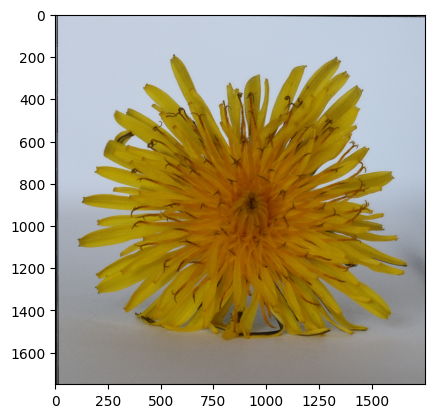

In [201]:
plt.figure()
plt.imshow(merged[:,:,[2,1,0]])

In [202]:
cv2.imwrite("merged.png", merged)

True

In [203]:
print(mask.shape[0])
# print(image_fi[les)

6


In [204]:
#TODO: make this array be determined from input file names?
reference_distances = [29, 33, 37, 40, 44, 46]
# furthest image is baseline and should have a depth of 0
# other images estimated in mm from base image
adjusted_distances = [ 17, 13, 9, 6, 2, 0 ]
normalized_distances = np.interp(adjusted_distances, (0, 17), (0, +255))

#TODO: is any additional scaling required? play around here, since we are not calculating with focal length like the paper

In [205]:
print(normalized_distances)

[255. 195. 135.  90.  30.   0.]


In [206]:
print(merged.shape)

(1750, 1750, 3)


This is the depth map with one layer added. You can see the stigma of the flower correctly
highlighted. These protrude from the base of the flower the most and are closest to the camera.


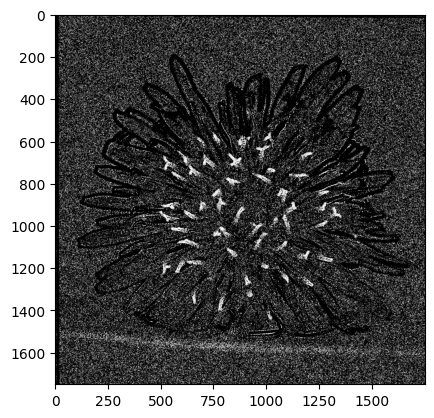

In [207]:
(H, W, _) = merged.shape
depth_map = np.zeros((H, W), dtype=np.uint8)
# depth_map[ones_mask==1] = normalized_distances[0]
depth_map[mask[0]==True] = normalized_distances[0]

plt.figure()
plt.imshow(depth_map, cmap="gray")

But I also see noise throughout the image background and solid portions of the petals. I'm not sure how this will affect our final rendering.

The examples in the paper we are implementing do not have this issue because the background is not visible in the sample images. We get just a square section of the surface of the mineral and bug they photographed.

Ideas to resolve:
    - crop our image further to a square, to remove the background around the flower
        - I don't like this option as much, at least for this sample, because we would loose the petal details, which are an important part of the flower.
    - foreground segmentation - write code to detect the mostly-white pixels in the merged image, null out these pixels' values in the depth map.
    -

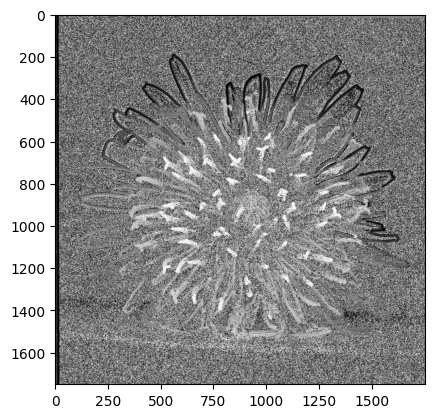

In [208]:
(H, W, _) = merged.shape
depth_map = np.zeros((H, W), dtype=np.uint8)
for i in range(mask.shape[0]):
    depth_map[mask[i]==True] = normalized_distances[i]

plt.figure()
plt.imshow(depth_map, cmap="gray")

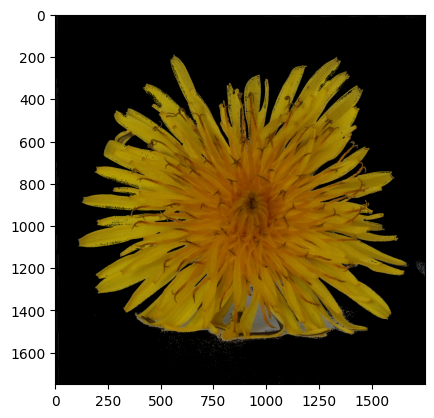

In [211]:
temp = filter_white_background(merged)
plt.figure()
plt.imshow(temp[:,:,[2,1,0]]) #, cmap="gray")

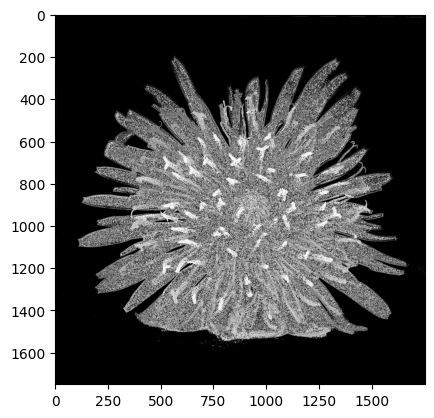

In [214]:
# mask = temp.copy()
# mask[mask>0] = 255
mask = cv2.cvtColor(temp, cv2.COLOR_BGR2GRAY)
mask[mask>0] = 255
img_bg = cv2.bitwise_and(depth_map, depth_map, mask=mask)
plt.figure()
plt.imshow(img_bg, cmap="gray")